Convolutional Dictionary Learning
=================================

This example demonstrates the use of [admm.cbpdndl.ConvBPDNDictLearn](http://sporco.rtfd.org/en/latest/sporco.admm.cbpdndl.html#sporco.admm.cbpdndl.ConvBPDNDictLearn) for learning a 3D convolutional dictionary from video data. The dictionary learning algorithm is based on the ADMM consensus dictionary update.

In [1]:
from __future__ import print_function
from builtins import input
from builtins import range

import os.path
import tempfile
import sys

import pyfftw   # See https://github.com/pyFFTW/pyFFTW/issues/40
import numpy as np

try:
    import skvideo.datasets
    import skvideo.io
except ImportError:
    print('Package sk-video is required by this demo script', file=sys.stderr)
    raise

from sporco.admm import cbpdndl
from sporco import util
from sporco import plot
plot.config_notebook_plotting()

Construct 3D training array from video data

In [2]:
vid = skvideo.io.vread(skvideo.datasets.fullreferencepair()[0],
                       outputdict={"-pix_fmt": "gray"})[..., 0]
vid = np.moveaxis(vid, 0, -1)
vid = vid[0:106,40:136, 10:42].astype(np.float32)/255.0

Highpass filter video frames.

In [3]:
npd = 16
fltlmbd = 10
vl, vh = util.tikhonov_filter(vid, fltlmbd, npd)

Construct initial dictionary.

In [4]:
np.random.seed(12345)
D0 = np.random.randn(5, 5, 3, 25)

Set regularization parameter and options for dictionary learning solver.

In [5]:
lmbda = 0.1
opt = cbpdndl.ConvBPDNDictLearn.Options({'Verbose': True, 'MaxMainIter': 200,
                'CBPDN': {'rho': 5e1*lmbda, 'AutoRho': {'Enabled': True}},
                'CCMOD': {'rho': 1e2, 'AutoRho': {'Enabled': True}}})

Create solver object and solve.

In [6]:
d = cbpdndl.ConvBPDNDictLearn(D0, vh, lmbda, opt, dimK=0, dimN=3)
D1 = d.solve()
print("ConvBPDNDictLearn solve time: %.2fs" % d.timer.elapsed('solve'))

Itn   Fnc       DFid      ℓ1        Cnstr     r_X       s_X       ρ_X       r_D       s_D       ρ_D       
--------------------------------------------------------------------------------------------------------


   0  1.42e+03  3.09e+01  1.39e+04  4.77e-07  9.49e-01  1.16e-01  5.00e+00  3.14e-01  1.65e-01  1.00e+02


   1  9.03e+02  1.08e+02  7.95e+03  3.76e-07  6.00e-01  3.24e-01  5.00e+00  2.80e-01  2.03e-01  1.00e+02


   2  9.44e+02  9.47e+01  8.49e+03  3.65e-07  3.88e-01  2.85e-01  5.00e+00  2.27e-01  1.34e-01  1.00e+02


   3  8.48e+02  7.46e+01  7.73e+03  4.85e-07  3.22e-01  2.40e-01  5.00e+00  2.04e-01  9.21e-02  1.00e+02


   4  6.55e+02  6.98e+01  5.85e+03  4.61e-07  2.83e-01  2.07e-01  5.00e+00  1.80e-01  8.69e-02  1.00e+02


   5  5.83e+02  7.19e+01  5.11e+03  4.00e-07  2.45e-01  1.39e-01  5.00e+00  1.44e-01  9.05e-02  1.00e+02


   6  5.45e+02  7.31e+01  4.72e+03  4.10e-07  1.95e-01  1.17e-01  5.00e+00  1.20e-01  8.53e-02  1.00e+02


   7  5.25e+02  7.08e+01  4.54e+03  6.17e-07  1.56e-01  1.00e-01  5.00e+00  9.12e-02  7.12e-02  1.00e+02


   8  5.03e+02  6.72e+01  4.35e+03  5.12e-07  1.32e-01  8.78e-02  5.00e+00  7.86e-02  6.03e-02  1.00e+02


   9  4.61e+02  6.45e+01  3.96e+03  5.35e-07  1.13e-01  8.06e-02  5.00e+00  6.56e-02  5.31e-02  1.00e+02


  10  4.29e+02  6.35e+01  3.65e+03  4.59e-07  9.87e-02  6.89e-02  5.00e+00  5.60e-02  4.86e-02  1.00e+02


  11  4.10e+02  6.34e+01  3.46e+03  5.05e-07  8.55e-02  5.91e-02  5.00e+00  4.72e-02  4.46e-02  1.00e+02


  12  3.96e+02  6.33e+01  3.33e+03  4.08e-07  7.31e-02  5.41e-02  5.00e+00  4.11e-02  4.05e-02  1.00e+02


  13  3.88e+02  6.27e+01  3.25e+03  4.53e-07  6.36e-02  4.94e-02  5.00e+00  3.47e-02  3.62e-02  1.00e+02


  14  3.80e+02  6.17e+01  3.18e+03  4.04e-07  5.60e-02  4.48e-02  5.00e+00  3.00e-02  3.27e-02  1.00e+02


  15  3.68e+02  6.09e+01  3.08e+03  4.64e-07  4.99e-02  4.16e-02  5.00e+00  2.67e-02  2.98e-02  1.00e+02


  16  3.57e+02  6.04e+01  2.97e+03  4.97e-07  4.48e-02  3.83e-02  5.00e+00  2.38e-02  2.76e-02  1.00e+02


  17  3.49e+02  6.01e+01  2.89e+03  4.38e-07  4.05e-02  3.51e-02  5.00e+00  2.12e-02  2.58e-02  1.00e+02


  18  3.42e+02  6.00e+01  2.82e+03  3.38e-07  3.67e-02  3.28e-02  5.00e+00  1.93e-02  2.43e-02  1.00e+02


  19  3.38e+02  5.98e+01  2.79e+03  4.82e-07  3.35e-02  3.07e-02  5.00e+00  1.76e-02  2.28e-02  1.00e+02


  20  3.35e+02  5.94e+01  2.75e+03  5.17e-07  3.08e-02  2.87e-02  5.00e+00  1.60e-02  2.15e-02  1.00e+02


  21  3.31e+02  5.90e+01  2.72e+03  3.37e-07  2.85e-02  2.71e-02  5.00e+00  1.47e-02  2.03e-02  1.00e+02


  22  3.27e+02  5.87e+01  2.68e+03  6.08e-07  2.65e-02  2.58e-02  5.00e+00  1.38e-02  1.93e-02  1.00e+02


  23  3.23e+02  5.84e+01  2.65e+03  5.91e-07  2.48e-02  2.44e-02  5.00e+00  1.29e-02  1.85e-02  1.00e+02


  24  3.20e+02  5.82e+01  2.62e+03  3.96e-07  2.33e-02  2.31e-02  5.00e+00  1.22e-02  1.78e-02  1.00e+02


  25  3.18e+02  5.81e+01  2.60e+03  5.60e-07  2.20e-02  2.20e-02  5.00e+00  1.14e-02  1.72e-02  1.00e+02


  26  3.16e+02  5.79e+01  2.58e+03  5.52e-07  2.08e-02  2.10e-02  5.00e+00  1.09e-02  1.67e-02  1.00e+02


  27  3.14e+02  5.76e+01  2.56e+03  4.59e-07  1.98e-02  2.02e-02  5.00e+00  1.04e-02  1.62e-02  1.00e+02


  28  3.12e+02  5.74e+01  2.55e+03  5.91e-07  1.89e-02  1.94e-02  5.00e+00  9.94e-03  1.58e-02  1.00e+02


  29  3.11e+02  5.72e+01  2.53e+03  4.87e-07  1.81e-02  1.86e-02  5.00e+00  9.52e-03  1.54e-02  1.00e+02


  30  3.09e+02  5.70e+01  2.52e+03  4.25e-07  1.74e-02  1.79e-02  5.00e+00  9.20e-03  1.51e-02  1.00e+02


  31  3.08e+02  5.68e+01  2.51e+03  5.14e-07  1.68e-02  1.73e-02  5.00e+00  8.94e-03  1.48e-02  1.00e+02


  32  3.07e+02  5.67e+01  2.50e+03  4.79e-07  1.62e-02  1.68e-02  5.00e+00  8.72e-03  1.45e-02  1.00e+02


  33  3.06e+02  5.65e+01  2.49e+03  4.89e-07  1.57e-02  1.63e-02  5.00e+00  8.46e-03  1.43e-02  1.00e+02


  34  3.05e+02  5.63e+01  2.48e+03  5.33e-07  1.53e-02  1.58e-02  5.00e+00  8.25e-03  1.40e-02  1.00e+02


  35  3.04e+02  5.62e+01  2.47e+03  4.34e-07  1.49e-02  1.54e-02  5.00e+00  8.06e-03  1.37e-02  1.00e+02


  36  3.03e+02  5.60e+01  2.47e+03  2.80e-07  1.45e-02  1.50e-02  5.00e+00  7.90e-03  1.35e-02  1.00e+02


  37  3.02e+02  5.58e+01  2.46e+03  5.11e-07  1.42e-02  1.46e-02  5.00e+00  7.76e-03  1.33e-02  1.00e+02


  38  3.01e+02  5.57e+01  2.45e+03  5.77e-07  1.39e-02  1.43e-02  5.00e+00  7.63e-03  1.31e-02  1.00e+02


  39  3.00e+02  5.56e+01  2.45e+03  4.17e-07  1.37e-02  1.40e-02  5.00e+00  7.51e-03  1.29e-02  1.00e+02


  40  3.00e+02  5.54e+01  2.44e+03  4.10e-07  1.34e-02  1.38e-02  5.00e+00  7.42e-03  1.27e-02  1.00e+02


  41  2.99e+02  5.53e+01  2.44e+03  5.19e-07  1.32e-02  1.36e-02  5.00e+00  7.32e-03  1.25e-02  1.00e+02


  42  2.98e+02  5.52e+01  2.43e+03  4.92e-07  1.30e-02  1.33e-02  5.00e+00  7.23e-03  1.23e-02  1.00e+02


  43  2.98e+02  5.51e+01  2.43e+03  4.00e-07  1.28e-02  1.32e-02  5.00e+00  7.14e-03  1.21e-02  1.00e+02


  44  2.97e+02  5.50e+01  2.42e+03  5.08e-07  1.26e-02  1.30e-02  5.00e+00  7.05e-03  1.19e-02  1.00e+02


  45  2.97e+02  5.49e+01  2.42e+03  4.04e-07  1.24e-02  1.28e-02  5.00e+00  6.94e-03  1.17e-02  1.00e+02


  46  2.96e+02  5.48e+01  2.41e+03  4.67e-07  1.22e-02  1.26e-02  5.00e+00  6.85e-03  1.14e-02  1.00e+02


  47  2.96e+02  5.46e+01  2.41e+03  4.93e-07  1.21e-02  1.24e-02  5.00e+00  6.75e-03  1.12e-02  1.00e+02


  48  2.95e+02  5.45e+01  2.40e+03  4.48e-07  1.19e-02  1.23e-02  5.00e+00  6.65e-03  1.09e-02  1.00e+02


  49  2.95e+02  5.45e+01  2.40e+03  5.42e-07  1.17e-02  1.21e-02  5.00e+00  6.55e-03  1.07e-02  1.00e+02


  50  2.94e+02  5.44e+01  2.40e+03  3.86e-07  1.15e-02  1.19e-02  5.00e+00  6.44e-03  1.04e-02  1.00e+02


  51  2.94e+02  5.43e+01  2.39e+03  5.30e-07  1.13e-02  1.17e-02  5.00e+00  6.34e-03  1.02e-02  1.00e+02


  52  2.93e+02  5.42e+01  2.39e+03  3.68e-07  1.11e-02  1.16e-02  5.00e+00  6.23e-03  9.93e-03  1.00e+02


  53  2.92e+02  5.41e+01  2.38e+03  4.81e-07  1.09e-02  1.14e-02  5.00e+00  6.13e-03  9.69e-03  1.00e+02


  54  2.92e+02  5.40e+01  2.38e+03  5.08e-07  1.07e-02  1.13e-02  5.00e+00  6.03e-03  9.46e-03  1.00e+02


  55  2.92e+02  5.40e+01  2.38e+03  4.61e-07  1.05e-02  1.11e-02  5.00e+00  5.93e-03  9.24e-03  1.00e+02


  56  2.91e+02  5.39e+01  2.37e+03  4.65e-07  1.03e-02  1.10e-02  5.00e+00  5.84e-03  9.03e-03  1.00e+02


  57  2.91e+02  5.39e+01  2.37e+03  5.34e-07  1.01e-02  1.08e-02  5.00e+00  5.73e-03  8.84e-03  1.00e+02


  58  2.90e+02  5.38e+01  2.36e+03  5.01e-07  9.94e-03  1.06e-02  5.00e+00  5.64e-03  8.64e-03  1.00e+02


  59  2.90e+02  5.37e+01  2.36e+03  4.88e-07  9.76e-03  1.05e-02  5.00e+00  5.55e-03  8.46e-03  1.00e+02


  60  2.89e+02  5.37e+01  2.36e+03  4.55e-07  9.58e-03  1.03e-02  5.00e+00  5.45e-03  8.28e-03  1.00e+02


  61  2.89e+02  5.36e+01  2.35e+03  5.12e-07  9.42e-03  1.02e-02  5.00e+00  5.36e-03  8.12e-03  1.00e+02


  62  2.89e+02  5.36e+01  2.35e+03  4.35e-07  9.25e-03  1.01e-02  5.00e+00  5.28e-03  7.96e-03  1.00e+02


  63  2.88e+02  5.35e+01  2.35e+03  4.91e-07  9.10e-03  9.93e-03  5.00e+00  5.20e-03  7.82e-03  1.00e+02


  64  2.88e+02  5.35e+01  2.34e+03  4.83e-07  8.94e-03  9.78e-03  5.00e+00  5.13e-03  7.68e-03  1.00e+02


  65  2.87e+02  5.34e+01  2.34e+03  4.05e-07  8.79e-03  9.64e-03  5.00e+00  5.07e-03  7.56e-03  1.00e+02


  66  2.87e+02  5.34e+01  2.34e+03  5.38e-07  8.65e-03  9.50e-03  5.00e+00  5.00e-03  7.44e-03  1.00e+02


  67  2.87e+02  5.33e+01  2.33e+03  4.55e-07  8.51e-03  9.36e-03  5.00e+00  4.93e-03  7.32e-03  1.00e+02


  68  2.86e+02  5.33e+01  2.33e+03  4.06e-07  8.38e-03  9.20e-03  5.00e+00  4.85e-03  7.21e-03  1.00e+02


  69  2.86e+02  5.33e+01  2.33e+03  5.15e-07  8.26e-03  9.07e-03  5.00e+00  4.79e-03  7.10e-03  1.00e+02


  70  2.86e+02  5.32e+01  2.33e+03  4.68e-07  8.12e-03  8.94e-03  5.00e+00  4.73e-03  6.99e-03  1.00e+02


  71  2.85e+02  5.32e+01  2.32e+03  5.48e-07  8.00e-03  8.82e-03  5.00e+00  4.66e-03  6.89e-03  1.00e+02


  72  2.85e+02  5.32e+01  2.32e+03  5.17e-07  7.89e-03  8.71e-03  5.00e+00  4.61e-03  6.79e-03  1.00e+02


  73  2.85e+02  5.31e+01  2.32e+03  4.99e-07  7.77e-03  8.60e-03  5.00e+00  4.54e-03  6.70e-03  1.00e+02


  74  2.85e+02  5.31e+01  2.31e+03  4.13e-07  7.67e-03  8.48e-03  5.00e+00  4.49e-03  6.62e-03  1.00e+02


  75  2.84e+02  5.31e+01  2.31e+03  3.93e-07  7.57e-03  8.38e-03  5.00e+00  4.43e-03  6.53e-03  1.00e+02


  76  2.84e+02  5.30e+01  2.31e+03  3.56e-07  7.46e-03  8.27e-03  5.00e+00  4.39e-03  6.45e-03  1.00e+02


  77  2.84e+02  5.30e+01  2.31e+03  4.87e-07  7.36e-03  8.17e-03  5.00e+00  4.33e-03  6.38e-03  1.00e+02


  78  2.84e+02  5.30e+01  2.31e+03  5.47e-07  7.27e-03  8.06e-03  5.00e+00  4.28e-03  6.30e-03  1.00e+02


  79  2.83e+02  5.29e+01  2.30e+03  4.98e-07  7.18e-03  7.93e-03  5.00e+00  4.22e-03  6.23e-03  1.00e+02


  80  2.83e+02  5.29e+01  2.30e+03  4.42e-07  7.08e-03  7.83e-03  5.00e+00  4.17e-03  6.16e-03  1.00e+02


  81  2.83e+02  5.29e+01  2.30e+03  4.60e-07  7.00e-03  7.74e-03  5.00e+00  4.13e-03  6.09e-03  1.00e+02


  82  2.83e+02  5.28e+01  2.30e+03  5.57e-07  6.91e-03  7.63e-03  5.00e+00  4.07e-03  6.03e-03  1.00e+02


  83  2.82e+02  5.28e+01  2.30e+03  4.41e-07  6.82e-03  7.54e-03  5.00e+00  4.03e-03  5.96e-03  1.00e+02


  84  2.82e+02  5.28e+01  2.29e+03  4.73e-07  6.75e-03  7.44e-03  5.00e+00  3.98e-03  5.90e-03  1.00e+02


  85  2.82e+02  5.28e+01  2.29e+03  5.40e-07  6.66e-03  7.33e-03  5.00e+00  3.94e-03  5.84e-03  1.00e+02


  86  2.82e+02  5.27e+01  2.29e+03  6.03e-07  6.59e-03  7.23e-03  5.00e+00  3.89e-03  5.78e-03  1.00e+02


  87  2.82e+02  5.27e+01  2.29e+03  4.73e-07  6.51e-03  7.14e-03  5.00e+00  3.84e-03  5.72e-03  1.00e+02


  88  2.81e+02  5.27e+01  2.29e+03  4.68e-07  6.43e-03  7.04e-03  5.00e+00  3.79e-03  5.66e-03  1.00e+02


  89  2.81e+02  5.26e+01  2.29e+03  4.23e-07  6.36e-03  6.95e-03  5.00e+00  3.75e-03  5.61e-03  1.00e+02


  90  2.81e+02  5.26e+01  2.28e+03  4.06e-07  6.29e-03  6.86e-03  5.00e+00  3.71e-03  5.56e-03  1.00e+02


  91  2.81e+02  5.26e+01  2.28e+03  4.75e-07  6.21e-03  6.79e-03  5.00e+00  3.68e-03  5.51e-03  1.00e+02


  92  2.81e+02  5.26e+01  2.28e+03  4.27e-07  6.16e-03  6.71e-03  5.00e+00  3.64e-03  5.46e-03  1.00e+02


  93  2.81e+02  5.25e+01  2.28e+03  4.99e-07  6.09e-03  6.63e-03  5.00e+00  3.61e-03  5.41e-03  1.00e+02


  94  2.80e+02  5.25e+01  2.28e+03  5.28e-07  6.04e-03  6.57e-03  5.00e+00  3.58e-03  5.37e-03  1.00e+02


  95  2.80e+02  5.25e+01  2.28e+03  4.34e-07  5.99e-03  6.51e-03  5.00e+00  3.55e-03  5.32e-03  1.00e+02


  96  2.80e+02  5.25e+01  2.28e+03  4.06e-07  5.94e-03  6.45e-03  5.00e+00  3.51e-03  5.28e-03  1.00e+02


  97  2.80e+02  5.24e+01  2.27e+03  4.66e-07  5.90e-03  6.39e-03  5.00e+00  3.49e-03  5.24e-03  1.00e+02


  98  2.80e+02  5.24e+01  2.27e+03  5.53e-07  5.85e-03  6.33e-03  5.00e+00  3.46e-03  5.21e-03  1.00e+02


  99  2.80e+02  5.24e+01  2.27e+03  4.66e-07  5.81e-03  6.27e-03  5.00e+00  3.43e-03  5.17e-03  1.00e+02


 100  2.80e+02  5.24e+01  2.27e+03  5.18e-07  5.76e-03  6.22e-03  5.00e+00  3.40e-03  5.13e-03  1.00e+02


 101  2.79e+02  5.23e+01  2.27e+03  5.05e-07  5.72e-03  6.17e-03  5.00e+00  3.38e-03  5.09e-03  1.00e+02


 102  2.79e+02  5.23e+01  2.27e+03  4.84e-07  5.68e-03  6.12e-03  5.00e+00  3.35e-03  5.06e-03  1.00e+02


 103  2.79e+02  5.23e+01  2.27e+03  5.31e-07  5.65e-03  6.08e-03  5.00e+00  3.33e-03  5.02e-03  1.00e+02


 104  2.79e+02  5.23e+01  2.27e+03  4.64e-07  5.61e-03  6.03e-03  5.00e+00  3.31e-03  4.98e-03  1.00e+02


 105  2.79e+02  5.22e+01  2.27e+03  5.08e-07  5.57e-03  5.97e-03  5.00e+00  3.29e-03  4.95e-03  1.00e+02


 106  2.79e+02  5.22e+01  2.27e+03  4.62e-07  5.54e-03  5.92e-03  5.00e+00  3.26e-03  4.92e-03  1.00e+02


 107  2.79e+02  5.22e+01  2.26e+03  4.78e-07  5.50e-03  5.87e-03  5.00e+00  3.24e-03  4.89e-03  1.00e+02


 108  2.79e+02  5.22e+01  2.26e+03  3.69e-07  5.47e-03  5.83e-03  5.00e+00  3.21e-03  4.85e-03  1.00e+02


 109  2.78e+02  5.21e+01  2.26e+03  4.62e-07  5.44e-03  5.79e-03  5.00e+00  3.19e-03  4.82e-03  1.00e+02


 110  2.78e+02  5.21e+01  2.26e+03  5.29e-07  5.41e-03  5.75e-03  5.00e+00  3.17e-03  4.79e-03  1.00e+02


 111  2.78e+02  5.21e+01  2.26e+03  6.39e-07  5.37e-03  5.70e-03  5.00e+00  3.15e-03  4.75e-03  1.00e+02


 112  2.78e+02  5.21e+01  2.26e+03  5.70e-07  5.34e-03  5.67e-03  5.00e+00  3.13e-03  4.71e-03  1.00e+02


 113  2.78e+02  5.20e+01  2.26e+03  6.39e-07  5.31e-03  5.63e-03  5.00e+00  3.11e-03  4.68e-03  1.00e+02


 114  2.78e+02  5.20e+01  2.26e+03  5.19e-07  5.28e-03  5.60e-03  5.00e+00  3.08e-03  4.64e-03  1.00e+02


 115  2.78e+02  5.20e+01  2.26e+03  5.63e-07  5.25e-03  5.56e-03  5.00e+00  3.06e-03  4.61e-03  1.00e+02


 116  2.78e+02  5.20e+01  2.26e+03  5.05e-07  5.22e-03  5.54e-03  5.00e+00  3.04e-03  4.57e-03  1.00e+02


 117  2.77e+02  5.19e+01  2.26e+03  5.15e-07  5.19e-03  5.51e-03  5.00e+00  3.02e-03  4.54e-03  1.00e+02


 118  2.77e+02  5.19e+01  2.25e+03  3.87e-07  5.15e-03  5.47e-03  5.00e+00  3.00e-03  4.50e-03  1.00e+02


 119  2.77e+02  5.19e+01  2.25e+03  4.96e-07  5.12e-03  5.44e-03  5.00e+00  2.98e-03  4.46e-03  1.00e+02


 120  2.77e+02  5.19e+01  2.25e+03  4.57e-07  5.09e-03  5.42e-03  5.00e+00  2.96e-03  4.43e-03  1.00e+02


 121  2.77e+02  5.18e+01  2.25e+03  4.91e-07  5.06e-03  5.39e-03  5.00e+00  2.94e-03  4.39e-03  1.00e+02


 122  2.77e+02  5.18e+01  2.25e+03  5.18e-07  5.03e-03  5.37e-03  5.00e+00  2.92e-03  4.36e-03  1.00e+02


 123  2.77e+02  5.18e+01  2.25e+03  4.21e-07  5.00e-03  5.34e-03  5.00e+00  2.89e-03  4.32e-03  1.00e+02


 124  2.77e+02  5.18e+01  2.25e+03  3.93e-07  4.97e-03  5.31e-03  5.00e+00  2.88e-03  4.29e-03  1.00e+02


 125  2.76e+02  5.18e+01  2.25e+03  5.73e-07  4.94e-03  5.29e-03  5.00e+00  2.85e-03  4.25e-03  1.00e+02


 126  2.76e+02  5.17e+01  2.25e+03  3.76e-07  4.91e-03  5.27e-03  5.00e+00  2.84e-03  4.22e-03  1.00e+02


 127  2.76e+02  5.17e+01  2.25e+03  4.99e-07  4.88e-03  5.25e-03  5.00e+00  2.81e-03  4.18e-03  1.00e+02


 128  2.76e+02  5.17e+01  2.24e+03  5.36e-07  4.86e-03  5.22e-03  5.00e+00  2.80e-03  4.15e-03  1.00e+02


 129  2.76e+02  5.17e+01  2.24e+03  5.43e-07  4.83e-03  5.20e-03  5.00e+00  2.78e-03  4.11e-03  1.00e+02


 130  2.76e+02  5.17e+01  2.24e+03  5.02e-07  4.79e-03  5.16e-03  5.00e+00  2.76e-03  4.07e-03  1.00e+02


 131  2.76e+02  5.16e+01  2.24e+03  4.44e-07  4.76e-03  5.12e-03  5.00e+00  2.73e-03  4.03e-03  1.00e+02


 132  2.76e+02  5.16e+01  2.24e+03  5.77e-07  4.72e-03  5.10e-03  5.00e+00  2.71e-03  3.99e-03  1.00e+02


 133  2.76e+02  5.16e+01  2.24e+03  5.38e-07  4.69e-03  5.06e-03  5.00e+00  2.69e-03  3.95e-03  1.00e+02


 134  2.75e+02  5.16e+01  2.24e+03  5.71e-07  4.65e-03  5.04e-03  5.00e+00  2.67e-03  3.91e-03  1.00e+02


 135  2.75e+02  5.16e+01  2.24e+03  6.60e-07  4.63e-03  5.01e-03  5.00e+00  2.65e-03  3.87e-03  1.00e+02


 136  2.75e+02  5.15e+01  2.24e+03  4.77e-07  4.59e-03  4.99e-03  5.00e+00  2.63e-03  3.83e-03  1.00e+02


 137  2.75e+02  5.15e+01  2.24e+03  4.24e-07  4.56e-03  4.96e-03  5.00e+00  2.61e-03  3.80e-03  1.00e+02


 138  2.75e+02  5.15e+01  2.24e+03  5.05e-07  4.53e-03  4.94e-03  5.00e+00  2.59e-03  3.76e-03  1.00e+02


 139  2.75e+02  5.15e+01  2.23e+03  4.24e-07  4.50e-03  4.92e-03  5.00e+00  2.56e-03  3.72e-03  1.00e+02


 140  2.75e+02  5.15e+01  2.23e+03  5.20e-07  4.46e-03  4.89e-03  5.00e+00  2.54e-03  3.68e-03  1.00e+02


 141  2.75e+02  5.14e+01  2.23e+03  5.89e-07  4.43e-03  4.86e-03  5.00e+00  2.52e-03  3.65e-03  1.00e+02


 142  2.75e+02  5.14e+01  2.23e+03  5.17e-07  4.40e-03  4.83e-03  5.00e+00  2.50e-03  3.61e-03  1.00e+02


 143  2.74e+02  5.14e+01  2.23e+03  5.82e-07  4.36e-03  4.80e-03  5.00e+00  2.48e-03  3.57e-03  1.00e+02


 144  2.74e+02  5.14e+01  2.23e+03  4.78e-07  4.32e-03  4.77e-03  5.00e+00  2.46e-03  3.52e-03  1.00e+02


 145  2.74e+02  5.14e+01  2.23e+03  5.27e-07  4.29e-03  4.74e-03  5.00e+00  2.44e-03  3.48e-03  1.00e+02


 146  2.74e+02  5.14e+01  2.23e+03  5.72e-07  4.25e-03  4.72e-03  5.00e+00  2.42e-03  3.45e-03  1.00e+02


 147  2.74e+02  5.13e+01  2.23e+03  5.47e-07  4.22e-03  4.69e-03  5.00e+00  2.40e-03  3.41e-03  1.00e+02


 148  2.74e+02  5.13e+01  2.23e+03  4.57e-07  4.18e-03  4.66e-03  5.00e+00  2.38e-03  3.38e-03  1.00e+02


 149  2.74e+02  5.13e+01  2.23e+03  5.87e-07  4.15e-03  4.63e-03  5.00e+00  2.36e-03  3.34e-03  1.00e+02


 150  2.74e+02  5.13e+01  2.22e+03  4.67e-07  4.11e-03  4.59e-03  5.00e+00  2.34e-03  3.31e-03  1.00e+02


 151  2.74e+02  5.13e+01  2.22e+03  7.32e-07  4.08e-03  4.56e-03  5.00e+00  2.31e-03  3.27e-03  1.00e+02


 152  2.74e+02  5.13e+01  2.22e+03  4.18e-07  4.04e-03  4.53e-03  5.00e+00  2.30e-03  3.23e-03  1.00e+02


 153  2.73e+02  5.12e+01  2.22e+03  5.10e-07  4.00e-03  4.49e-03  5.00e+00  2.27e-03  3.20e-03  1.00e+02


 154  2.73e+02  5.12e+01  2.22e+03  5.22e-07  3.96e-03  4.45e-03  5.00e+00  2.25e-03  3.16e-03  1.00e+02


 155  2.73e+02  5.12e+01  2.22e+03  4.83e-07  3.93e-03  4.41e-03  5.00e+00  2.23e-03  3.13e-03  1.00e+02


 156  2.73e+02  5.12e+01  2.22e+03  4.67e-07  3.89e-03  4.39e-03  5.00e+00  2.21e-03  3.09e-03  1.00e+02


 157  2.73e+02  5.12e+01  2.22e+03  4.80e-07  3.85e-03  4.35e-03  5.00e+00  2.18e-03  3.06e-03  1.00e+02


 158  2.73e+02  5.12e+01  2.22e+03  4.30e-07  3.81e-03  4.31e-03  5.00e+00  2.16e-03  3.02e-03  1.00e+02


 159  2.73e+02  5.12e+01  2.22e+03  4.02e-07  3.77e-03  4.27e-03  5.00e+00  2.14e-03  2.99e-03  1.00e+02


 160  2.73e+02  5.11e+01  2.22e+03  5.85e-07  3.73e-03  4.24e-03  5.00e+00  2.12e-03  2.96e-03  1.00e+02


 161  2.73e+02  5.11e+01  2.22e+03  4.29e-07  3.70e-03  4.21e-03  5.00e+00  2.10e-03  2.93e-03  1.00e+02


 162  2.73e+02  5.11e+01  2.21e+03  4.71e-07  3.67e-03  4.18e-03  5.00e+00  2.08e-03  2.90e-03  1.00e+02


 163  2.72e+02  5.11e+01  2.21e+03  6.39e-07  3.63e-03  4.15e-03  5.00e+00  2.07e-03  2.87e-03  1.00e+02


 164  2.72e+02  5.11e+01  2.21e+03  5.27e-07  3.60e-03  4.11e-03  5.00e+00  2.05e-03  2.85e-03  1.00e+02


 165  2.72e+02  5.11e+01  2.21e+03  5.08e-07  3.57e-03  4.08e-03  5.00e+00  2.03e-03  2.83e-03  1.00e+02


 166  2.72e+02  5.11e+01  2.21e+03  4.52e-07  3.53e-03  4.04e-03  5.00e+00  2.02e-03  2.81e-03  1.00e+02


 167  2.72e+02  5.11e+01  2.21e+03  4.18e-07  3.50e-03  4.01e-03  5.00e+00  2.00e-03  2.78e-03  1.00e+02


 168  2.72e+02  5.10e+01  2.21e+03  4.98e-07  3.47e-03  3.97e-03  5.00e+00  1.98e-03  2.76e-03  1.00e+02


 169  2.72e+02  5.10e+01  2.21e+03  5.06e-07  3.44e-03  3.94e-03  5.00e+00  1.97e-03  2.74e-03  1.00e+02


 170  2.72e+02  5.10e+01  2.21e+03  3.72e-07  3.41e-03  3.92e-03  5.00e+00  1.95e-03  2.72e-03  1.00e+02


 171  2.72e+02  5.10e+01  2.21e+03  5.01e-07  3.38e-03  3.89e-03  5.00e+00  1.93e-03  2.70e-03  1.00e+02


 172  2.72e+02  5.10e+01  2.21e+03  6.03e-07  3.35e-03  3.85e-03  5.00e+00  1.92e-03  2.68e-03  1.00e+02


 173  2.72e+02  5.10e+01  2.21e+03  4.46e-07  3.32e-03  3.82e-03  5.00e+00  1.90e-03  2.67e-03  1.00e+02


 174  2.72e+02  5.10e+01  2.21e+03  4.35e-07  3.30e-03  3.79e-03  5.00e+00  1.89e-03  2.65e-03  1.00e+02


 175  2.72e+02  5.10e+01  2.21e+03  5.60e-07  3.27e-03  3.76e-03  5.00e+00  1.87e-03  2.63e-03  1.00e+02


 176  2.72e+02  5.10e+01  2.21e+03  3.96e-07  3.24e-03  3.73e-03  5.00e+00  1.86e-03  2.62e-03  1.00e+02


 177  2.71e+02  5.09e+01  2.20e+03  4.58e-07  3.22e-03  3.70e-03  5.00e+00  1.84e-03  2.60e-03  1.00e+02


 178  2.71e+02  5.09e+01  2.20e+03  4.51e-07  3.19e-03  3.68e-03  5.00e+00  1.83e-03  2.59e-03  1.00e+02


 179  2.71e+02  5.09e+01  2.20e+03  4.98e-07  3.17e-03  3.65e-03  5.00e+00  1.82e-03  2.57e-03  1.00e+02


 180  2.71e+02  5.09e+01  2.20e+03  5.16e-07  3.14e-03  3.62e-03  5.00e+00  1.80e-03  2.56e-03  1.00e+02


 181  2.71e+02  5.09e+01  2.20e+03  4.67e-07  3.12e-03  3.60e-03  5.00e+00  1.79e-03  2.54e-03  1.00e+02


 182  2.71e+02  5.09e+01  2.20e+03  5.72e-07  3.09e-03  3.57e-03  5.00e+00  1.78e-03  2.53e-03  1.00e+02


 183  2.71e+02  5.09e+01  2.20e+03  5.14e-07  3.07e-03  3.55e-03  5.00e+00  1.76e-03  2.52e-03  1.00e+02


 184  2.71e+02  5.09e+01  2.20e+03  4.83e-07  3.05e-03  3.53e-03  5.00e+00  1.76e-03  2.51e-03  1.00e+02


 185  2.71e+02  5.09e+01  2.20e+03  4.89e-07  3.03e-03  3.50e-03  5.00e+00  1.74e-03  2.50e-03  1.00e+02


 186  2.71e+02  5.09e+01  2.20e+03  3.90e-07  3.01e-03  3.48e-03  5.00e+00  1.73e-03  2.49e-03  1.00e+02


 187  2.71e+02  5.08e+01  2.20e+03  4.69e-07  2.99e-03  3.46e-03  5.00e+00  1.72e-03  2.48e-03  1.00e+02


 188  2.71e+02  5.08e+01  2.20e+03  5.17e-07  2.97e-03  3.44e-03  5.00e+00  1.71e-03  2.47e-03  1.00e+02


 189  2.71e+02  5.08e+01  2.20e+03  5.21e-07  2.95e-03  3.42e-03  5.00e+00  1.70e-03  2.46e-03  1.00e+02


 190  2.71e+02  5.08e+01  2.20e+03  4.76e-07  2.93e-03  3.40e-03  5.00e+00  1.70e-03  2.45e-03  1.00e+02


 191  2.71e+02  5.08e+01  2.20e+03  6.44e-07  2.92e-03  3.38e-03  5.00e+00  1.69e-03  2.45e-03  1.00e+02


 192  2.71e+02  5.08e+01  2.20e+03  3.92e-07  2.90e-03  3.36e-03  5.00e+00  1.68e-03  2.44e-03  1.00e+02


 193  2.71e+02  5.08e+01  2.20e+03  6.15e-07  2.88e-03  3.34e-03  5.00e+00  1.67e-03  2.43e-03  1.00e+02


 194  2.70e+02  5.08e+01  2.20e+03  4.17e-07  2.86e-03  3.32e-03  5.00e+00  1.66e-03  2.43e-03  1.00e+02


 195  2.70e+02  5.08e+01  2.20e+03  4.50e-07  2.85e-03  3.30e-03  5.00e+00  1.65e-03  2.42e-03  1.00e+02


 196  2.70e+02  5.08e+01  2.20e+03  4.53e-07  2.83e-03  3.28e-03  5.00e+00  1.65e-03  2.41e-03  1.00e+02


 197  2.70e+02  5.08e+01  2.20e+03  4.89e-07  2.82e-03  3.27e-03  5.00e+00  1.64e-03  2.41e-03  1.00e+02


 198  2.70e+02  5.07e+01  2.20e+03  6.11e-07  2.80e-03  3.25e-03  5.00e+00  1.63e-03  2.40e-03  1.00e+02


 199  2.70e+02  5.07e+01  2.20e+03  5.06e-07  2.79e-03  3.23e-03  5.00e+00  1.63e-03  2.40e-03  1.00e+02
--------------------------------------------------------------------------------------------------------
ConvBPDNDictLearn solve time: 243.59s


Display initial and final dictionaries: central temporal slice

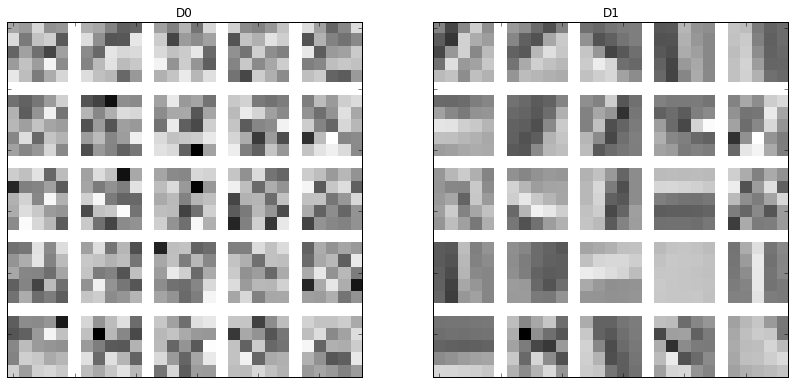

In [7]:
D1 = D1.squeeze()
fig = plot.figure(figsize=(14,7))
plot.subplot(1, 2, 1)
plot.imview(util.tiledict(D0[...,2,:]), fig=fig, title='D0')
plot.subplot(1, 2, 2)
plot.imview(util.tiledict(D1[...,2,:]), fig=fig, title='D1')
fig.show()

Display initial and final dictionaries: central spatial vertical slice

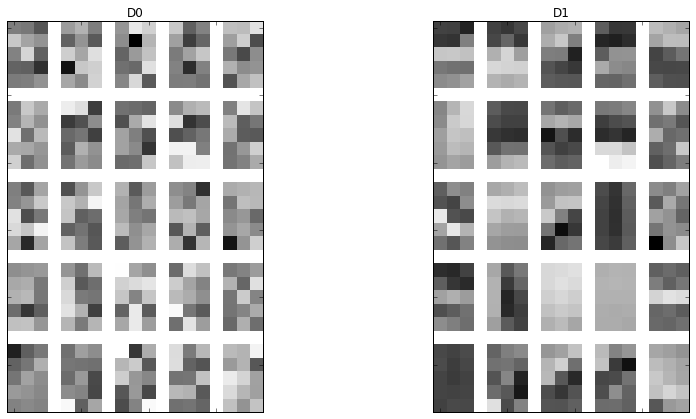

In [8]:
D1 = D1.squeeze()
fig = plot.figure(figsize=(14, 7))
plot.subplot(1, 2, 1)
plot.imview(util.tiledict(D0[2]), fig=fig, title='D0')
plot.subplot(1, 2, 2)
plot.imview(util.tiledict(D1[2]), fig=fig, title='D1')
fig.show()

Get iterations statistics from solver object and plot functional value, ADMM primary and dual residuals, and automatically adjusted ADMM penalty parameter against the iteration number.

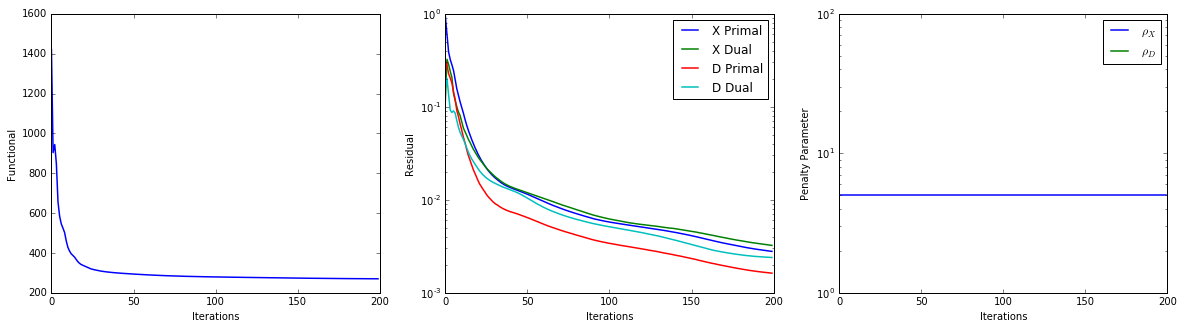

In [9]:
its = d.getitstat()
fig = plot.figure(figsize=(20, 5))
plot.subplot(1, 3, 1)
plot.plot(its.ObjFun, xlbl='Iterations', ylbl='Functional', fig=fig)
plot.subplot(1, 3, 2)
plot.plot(np.vstack((its.XPrRsdl, its.XDlRsdl, its.DPrRsdl, its.DDlRsdl)).T,
          ptyp='semilogy', xlbl='Iterations', ylbl='Residual',
          lgnd=['X Primal', 'X Dual', 'D Primal', 'D Dual'], fig=fig)
plot.subplot(1, 3, 3)
plot.plot(np.vstack((its.XRho, its.DRho)).T, xlbl='Iterations',
          ylbl='Penalty Parameter', ptyp='semilogy',
          lgnd=['$\\rho_X$', '$\\rho_D$'], fig=fig)
fig.show()